<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/pseudotime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon Aug 17 23:21:51 UTC 2020


In [2]:
#Read in kallisto bus fed/starved data
!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [98]:
#Neuron subpopulations
!wget --quiet https://caltech.box.com/shared/static/dmxm8qmq1epa4z71l0j7v728gam2olp2

In [3]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [4]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 7.7MB 2.5MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 25.5MB/s 
     |████████████████████████████████| 2.2MB 2.8MB/s 


In [5]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")


In [6]:
#Read in annotation data
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

In [99]:
#Read in saved data
bus_fs_combo = anndata.read('13jsqkczkskrf6cau9p4evhnmqyp7jn3')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
print(bus_fs_raw)

neuron_subpops  = anndata.read('dmxm8qmq1epa4z71l0j7v728gam2olp2')
print(neuron_subpops)

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID'
AnnData object with n_obs × n_vars = 1387 × 2852
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'louvain_neur'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cellRanger_louvain_colors', 'fed_neighbor_score_colors', 'hvg', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'louvain_neur_colors', 'neighbors', 'pca', 'rank_gen

In [25]:
#Subset data

#I-cells and neurons
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0])]



sc.pp.filter_cells(neur_lin, min_counts=0)
sc.pp.filter_genes(neur_lin, min_counts=1)
sc.pp.normalize_per_cell(neur_lin, counts_per_cell_after=1e4)

sc.pp.log1p(neur_lin)


sc.pp.highly_variable_genes(neur_lin, n_top_genes=2000)

neur_lin = neur_lin[:,neur_lin.var['highly_variable']]

neur_lin

#I-cells, neurons, cnidocytes, gland cells

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 2662 × 1999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

###**I-cells and Neurons**

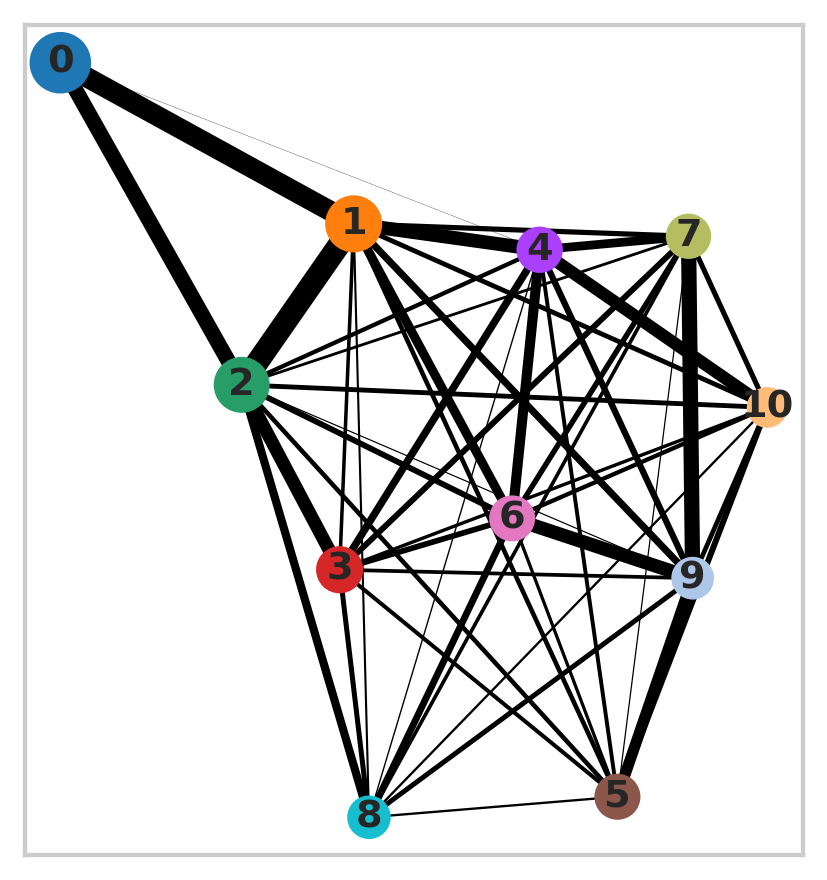

In [43]:
#I-cell + neurons PAGA embedding
neur_lin_scaled = neur_lin
sc.pp.scale(neur_lin_scaled, max_value=10)

sc.tl.pca(neur_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)

sc.pp.neighbors(neur_lin_scaled,n_neighbors=50, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'

sc.tl.louvain(neur_lin_scaled,resolution=1,key_added='louvain_test')#Clustering algorithm,resolution=0.5

sc.tl.paga(neur_lin_scaled, groups='louvain_test' )
sc.pl.paga(neur_lin_scaled, color=['louvain_test'])

In [100]:
#Add neuron subpopulation labels
labels = []
for c in neur_lin_scaled.obs_names:
  if c in neuron_subpops.obs_names:

    labels += [neuron_subpops[c,:].obs['louvain_neur'][0]]
  else:
    labels += ['stem']

neur_lin_scaled.obs['louvain_neur'] = pd.Categorical(labels)

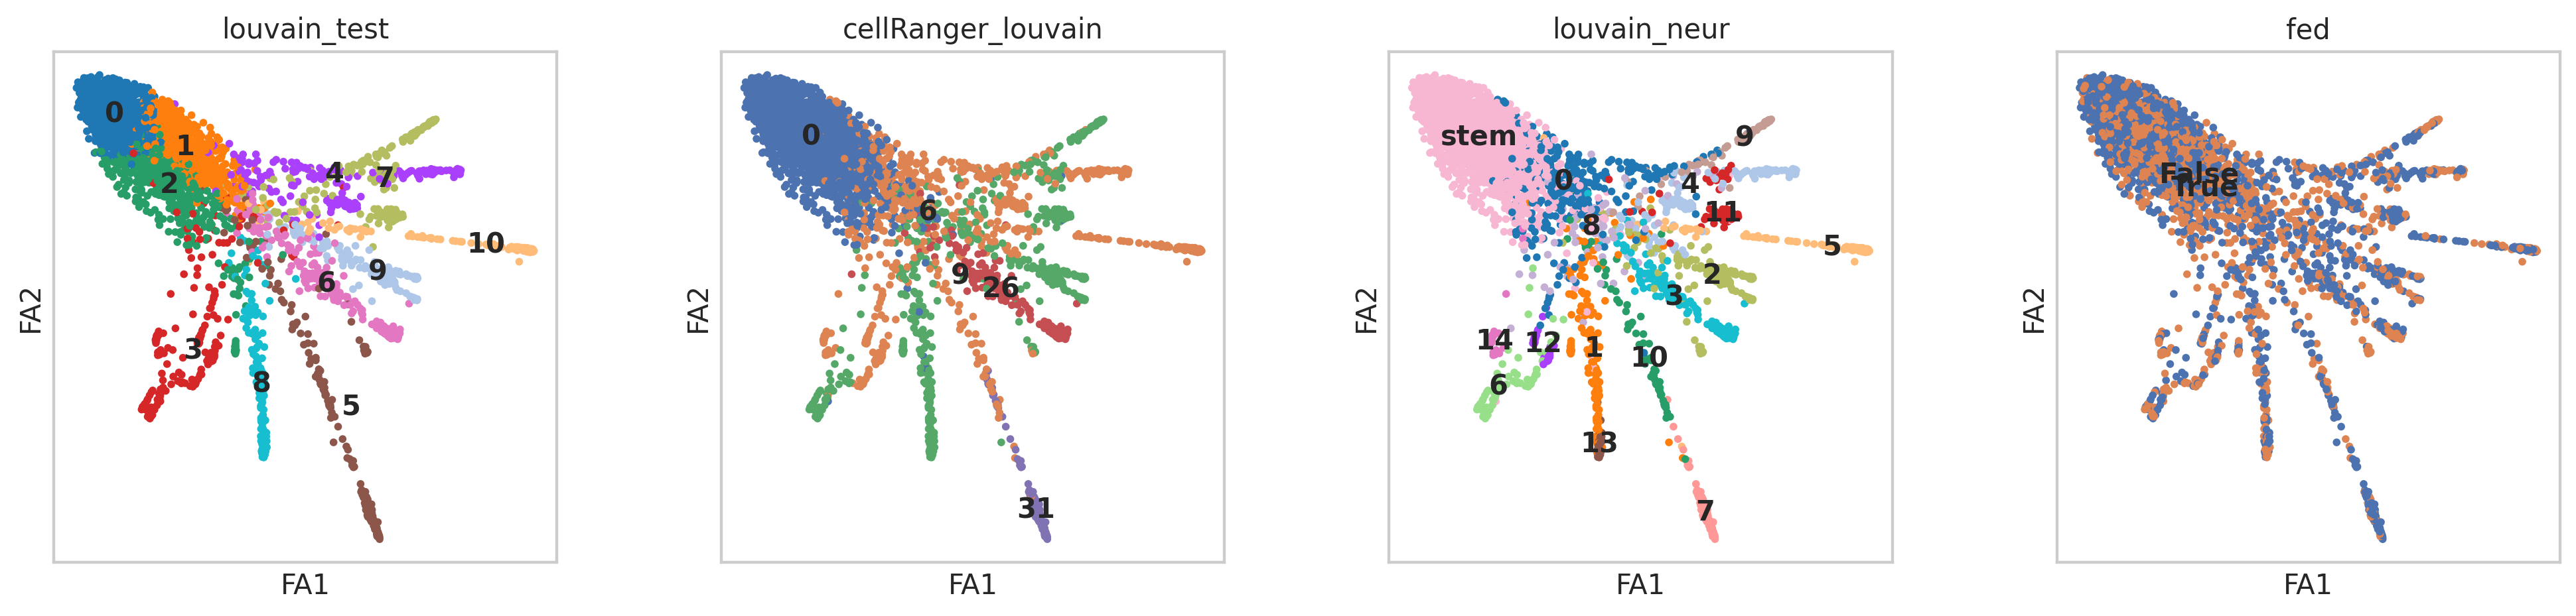

In [101]:
sc.tl.draw_graph(neur_lin_scaled, init_pos='paga')
sc.pl.draw_graph(neur_lin_scaled, color=['louvain_test','cellRanger_louvain','louvain_neur','fed'], legend_loc='on data',color_map='viridis')

In [33]:
#Calculate pseudotime with diffusion components (dim reduction)

neur_lin_scaled.uns['iroot'] = np.flatnonzero(neur_lin_scaled.obs['louvain_neur']  == '0')[0]
sc.tl.dpt(neur_lin_scaled)


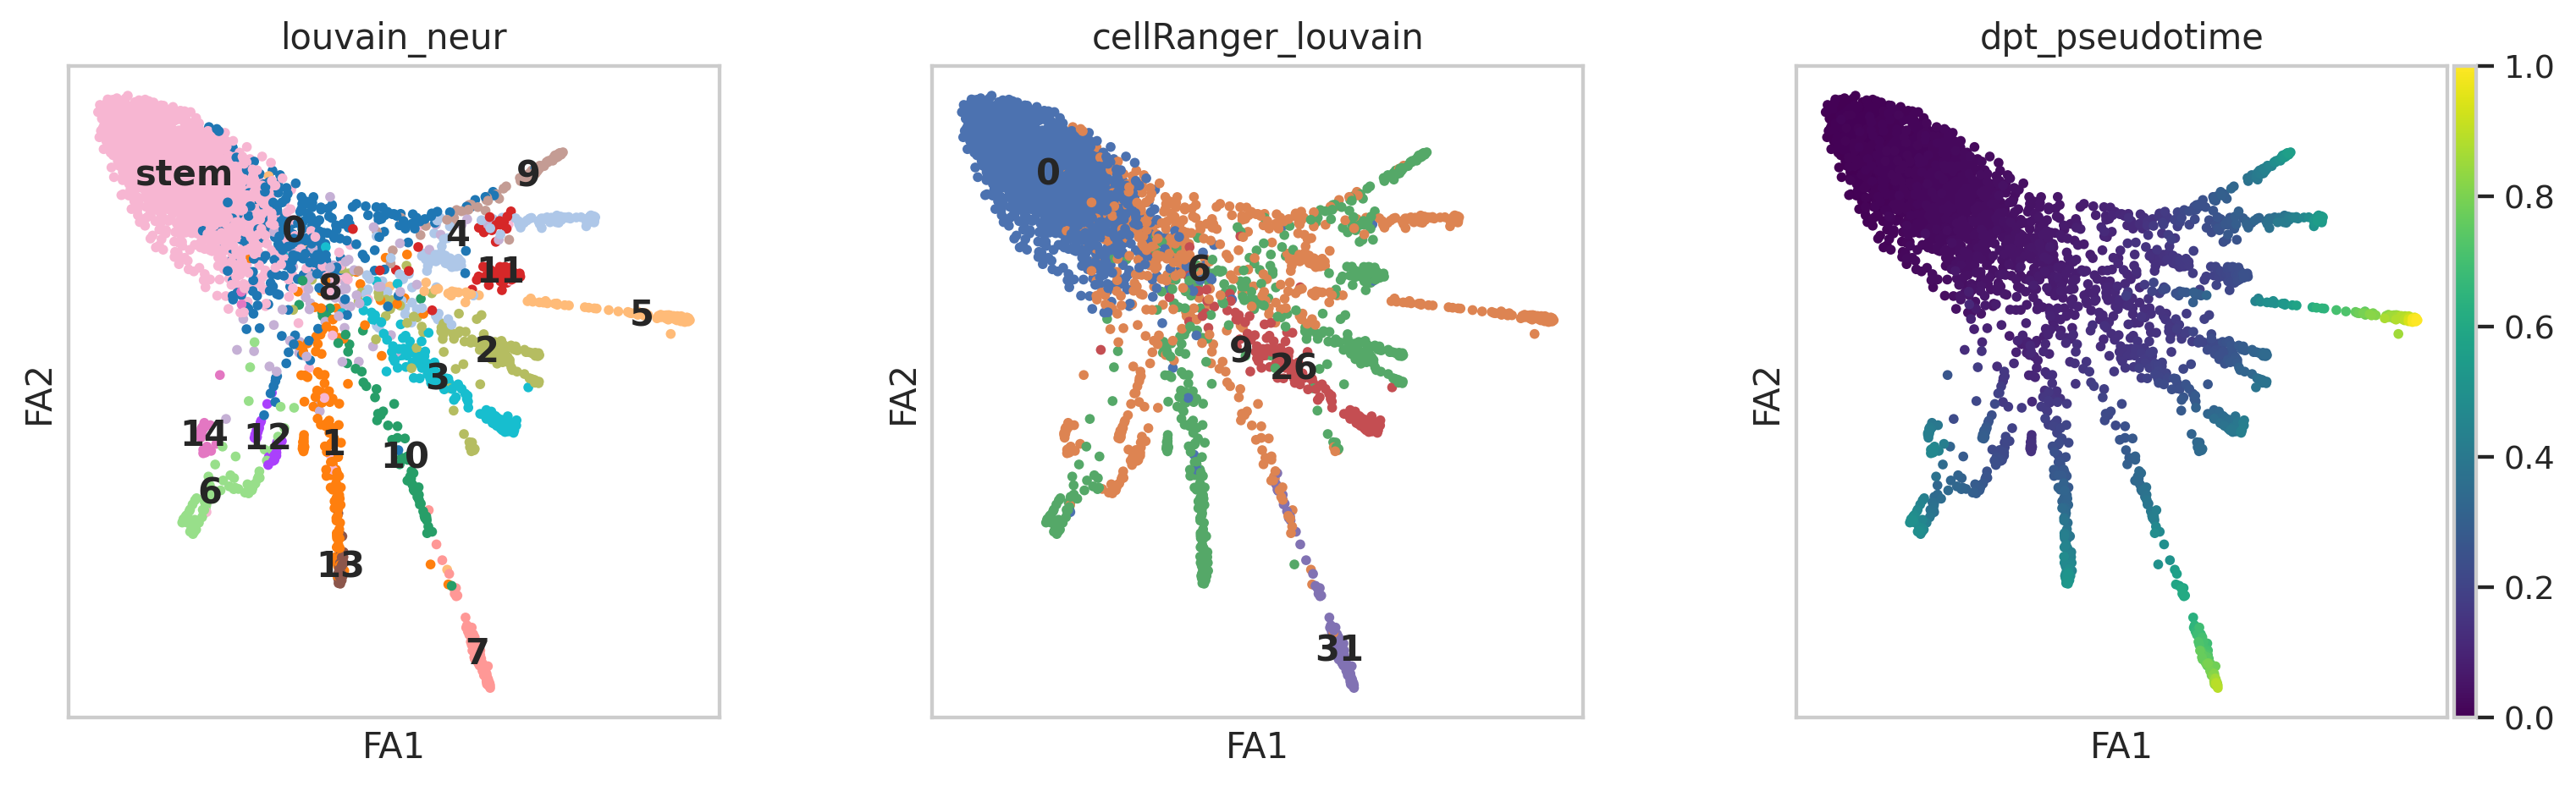

In [102]:
sc.pl.draw_graph(neur_lin_scaled, color=['louvain_neur','cellRanger_louvain', 'dpt_pseudotime'], legend_loc='on data',color_map='viridis')

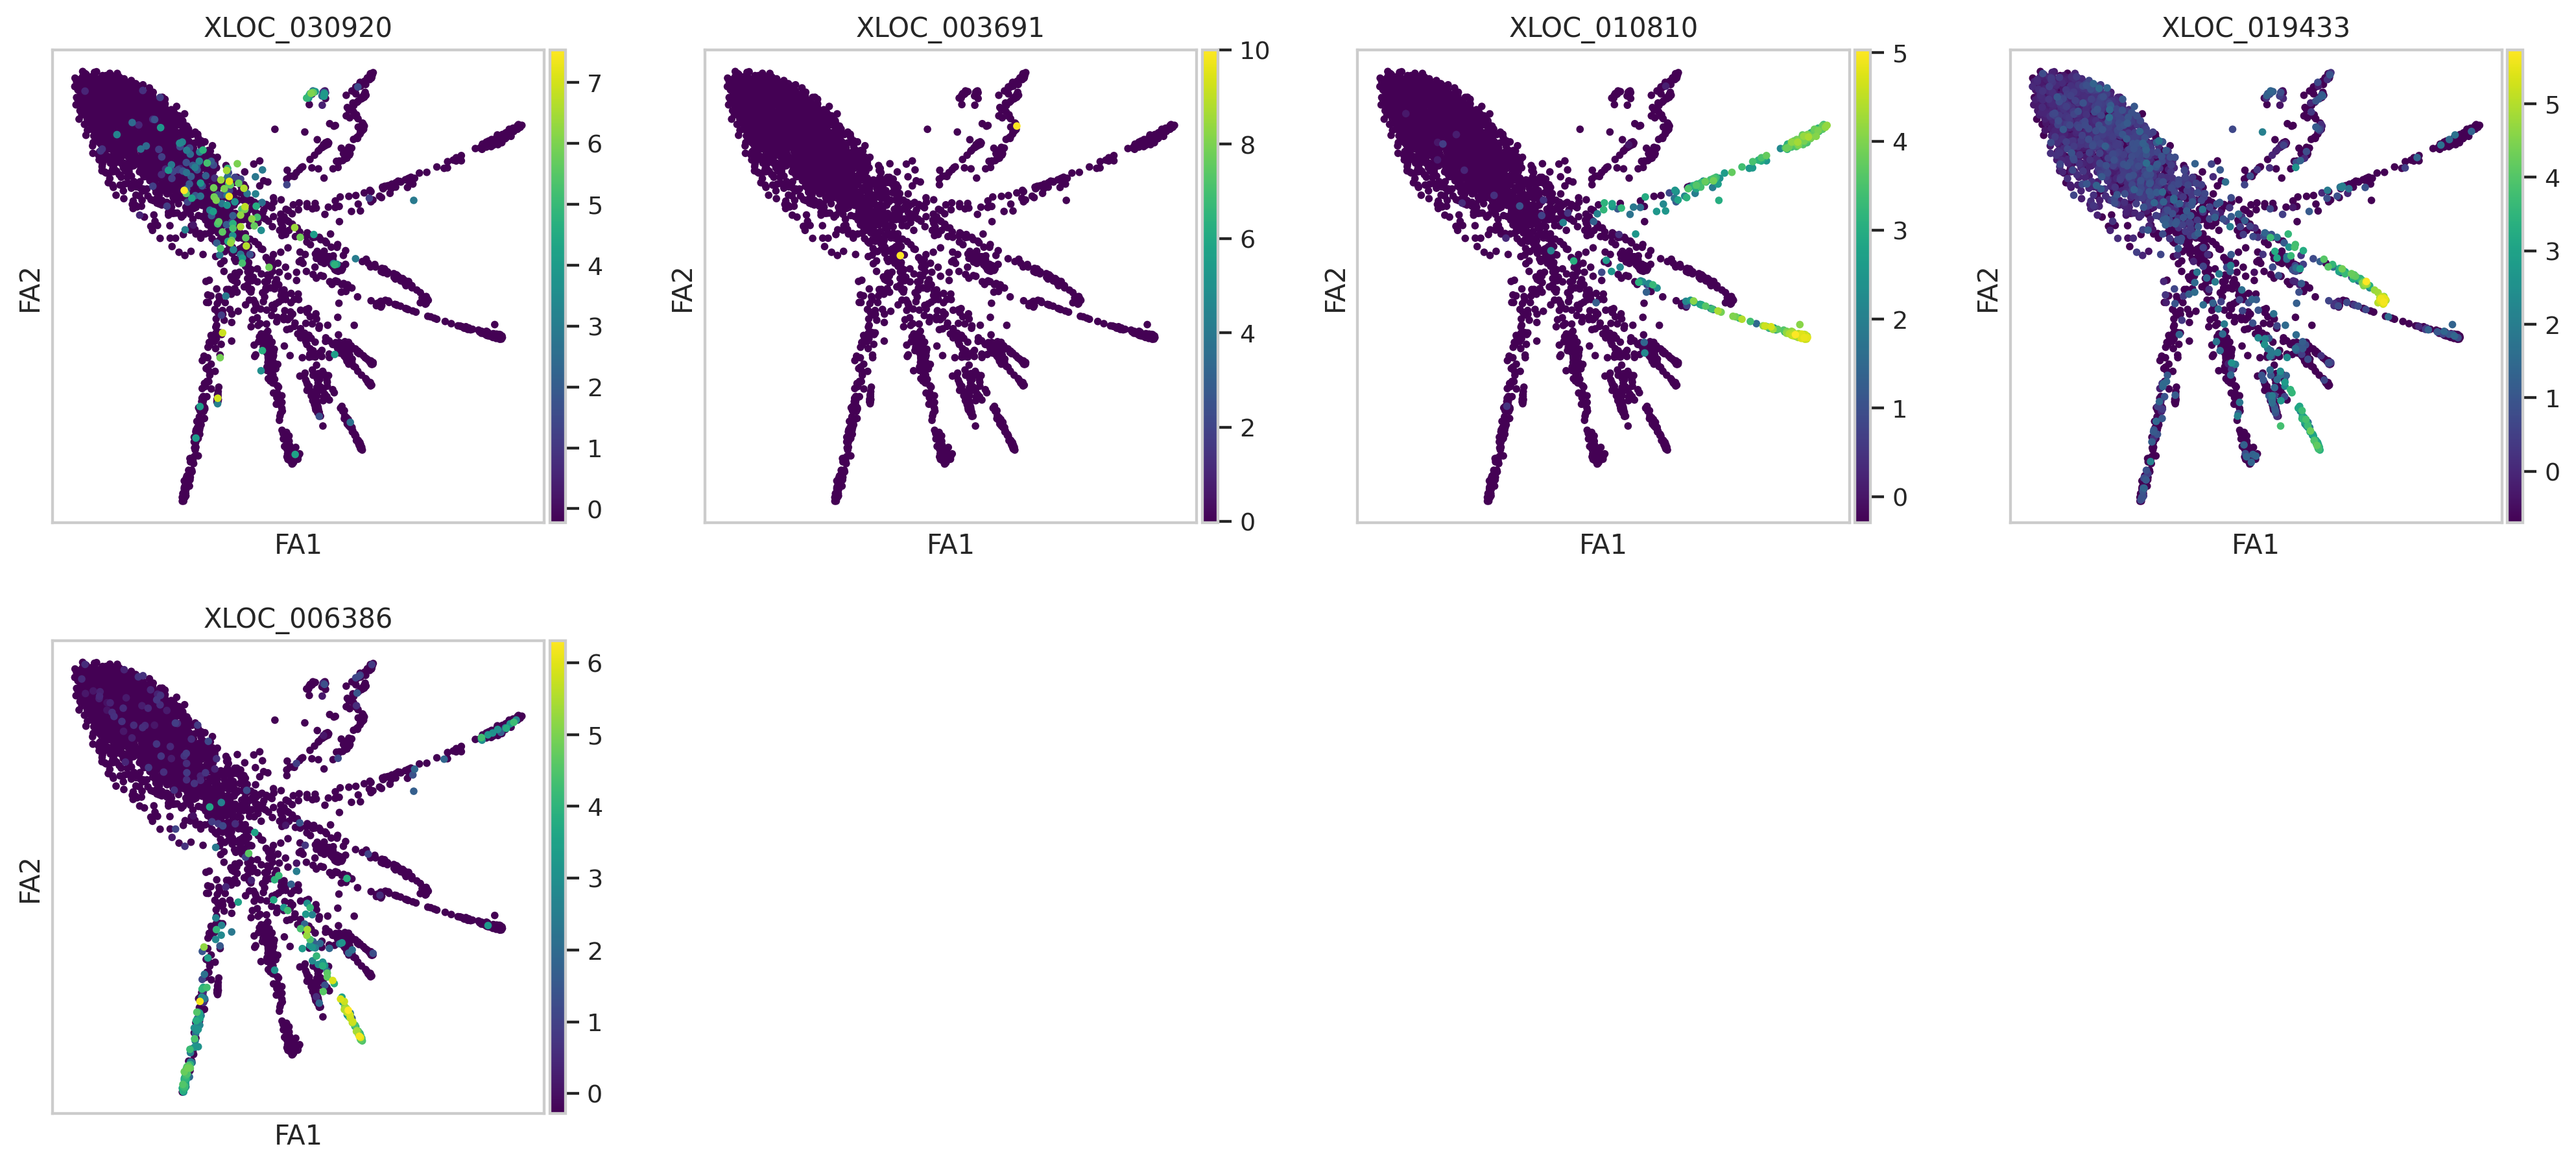

In [39]:
sc.pl.draw_graph(neur_lin_scaled, color=[ 'XLOC_030920','XLOC_003691','XLOC_010810','XLOC_019433','XLOC_006386'], 
                 legend_loc='on data',color_map='viridis')

In [36]:
#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

X = neur_lin.X
n = np.int(0.9*X.shape[0])
indices = np.random.choice(X.shape[0], n, replace=False)
X_train = X[indices,:]

y = neur_lin_scaled.obs['dpt_pseudotime']
y_train = y[indices]

X_test = X[[i for i in range(0,X.shape[0]) if i not in indices],:]
y_test = y[[i for i in range(0,X.shape[0]) if i not in indices]]

regr = RandomForestRegressor(random_state=42)
regr.fit(X_train, y_train)
result = permutation_importance(regr, X_test, y_test, n_repeats=5, random_state=42)



In [38]:
neur_gene_res = pd.DataFrame()
neur_gene_res['Genes'] = neur_lin_scaled.var_names
neur_gene_res['Mean'] = result.importances_mean
neur_gene_res['Std'] = result.importances_std

neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

print(len(neur_gene_res.Genes))
neur_gene_res.head()


494


Genes      Mean       Std
546                   XLOC_010810  0.557580  0.045415
914                   XLOC_019433  0.037008  0.007830
411                   XLOC_008165  0.029550  0.005352
1516  TRINITY_DN89_c0_g1_i2.mrna1  0.027271  0.002619
1401                  XLOC_033336  0.020905  0.002865

In [60]:
#Make dataframe, with 100 marker genes for each cluster + annotations

orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

genes = neur_gene_res.Genes

for g in genes:
        
  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']


  if len(panth_df) > 0:
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
 

neur_gene_res['orthoGene'] = orthoGene
neur_gene_res['orthoDescr'] = orthoDescr

neur_gene_res['pantherID'] = pantherNum
neur_gene_res['pantherDescr'] = pantherDescr

neur_gene_res['goTerms'] = goTerms
     
neur_gene_res.head()
#list(neurons.uns['rank_genes_groups']['names']['1'])




Genes  ...                                            goTerms
546                   XLOC_010810  ...                                              [nan]
914                   XLOC_019433  ...  [GO:0005737,GO:0044238,GO:0016020,GO:0032991,G...
411                   XLOC_008165  ...  [GO:0005737,GO:0044238,GO:0005622,GO:0032991,G...
1516  TRINITY_DN89_c0_g1_i2.mrna1  ...                                                 NA
1401                  XLOC_033336  ...                                              [nan]

[5 rows x 8 columns]

In [61]:
neur_gene_res.to_csv('neural_lineage_pseudotime_genes.csv')

####Group Pseudotime-variant Genes

Trying to set attribute `.obs` of view, copying.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

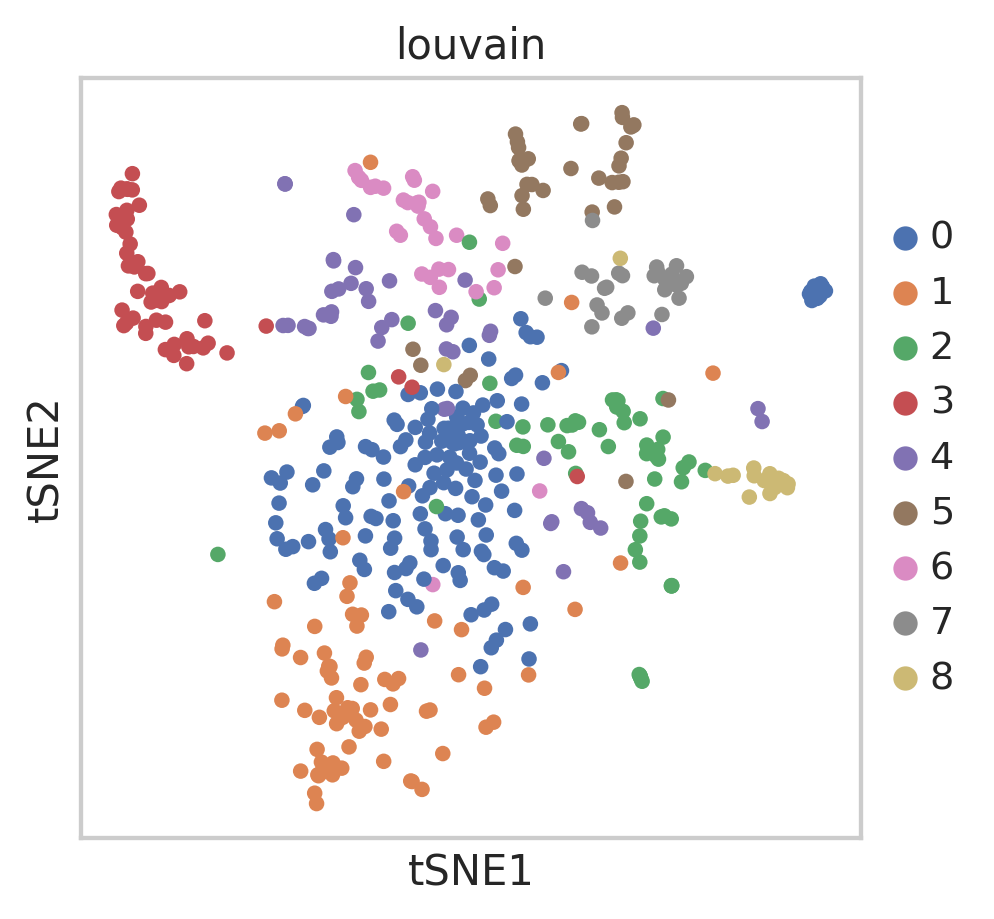

In [91]:
#Filter raw count dataset
bus_fs_raw = bus_fs_raw [:,np.unique(neur_gene_res.Genes)]
bus_fs_raw =bus_fs_raw[neur_lin_scaled.obs_names,:]
bus_fs_raw.obs['cellRanger_louvain'] = neur_lin_scaled.obs['cellRanger_louvain']
bus_fs_raw.obs['fed'] = neur_lin_scaled.obs['fed']

de_gene_adata = anndata.AnnData(X=bus_fs_raw.X.T)
de_gene_adata.var_names = bus_fs_raw.obs_names
de_gene_adata.obs_names = bus_fs_raw.var_names
#de_gene_adata

#Normalize and scale data
sc.pp.filter_genes(de_gene_adata, min_counts=0)

sc.pp.normalize_per_cell(de_gene_adata, counts_per_cell_after=1e4)
de_gene_adata.raw = sc.pp.log1p(de_gene_adata, copy=True)

sc.pp.scale(de_gene_adata, max_value=10)
sc.tl.pca(de_gene_adata, n_comps=60)
#sc.pl.pca_variance_ratio(bus_combo, log=True)

#Determine neighbors for clustering
sc.pp.neighbors(de_gene_adata,n_neighbors=15, n_pcs=30) #n_neighbors=5, n_pcs=15,  20, n_pcs=15
sc.tl.louvain(de_gene_adata,resolution=1)

sc.tl.tsne(de_gene_adata, n_pcs=30,random_state=42)
sc.pl.tsne(de_gene_adata,color=['louvain'],size=80)

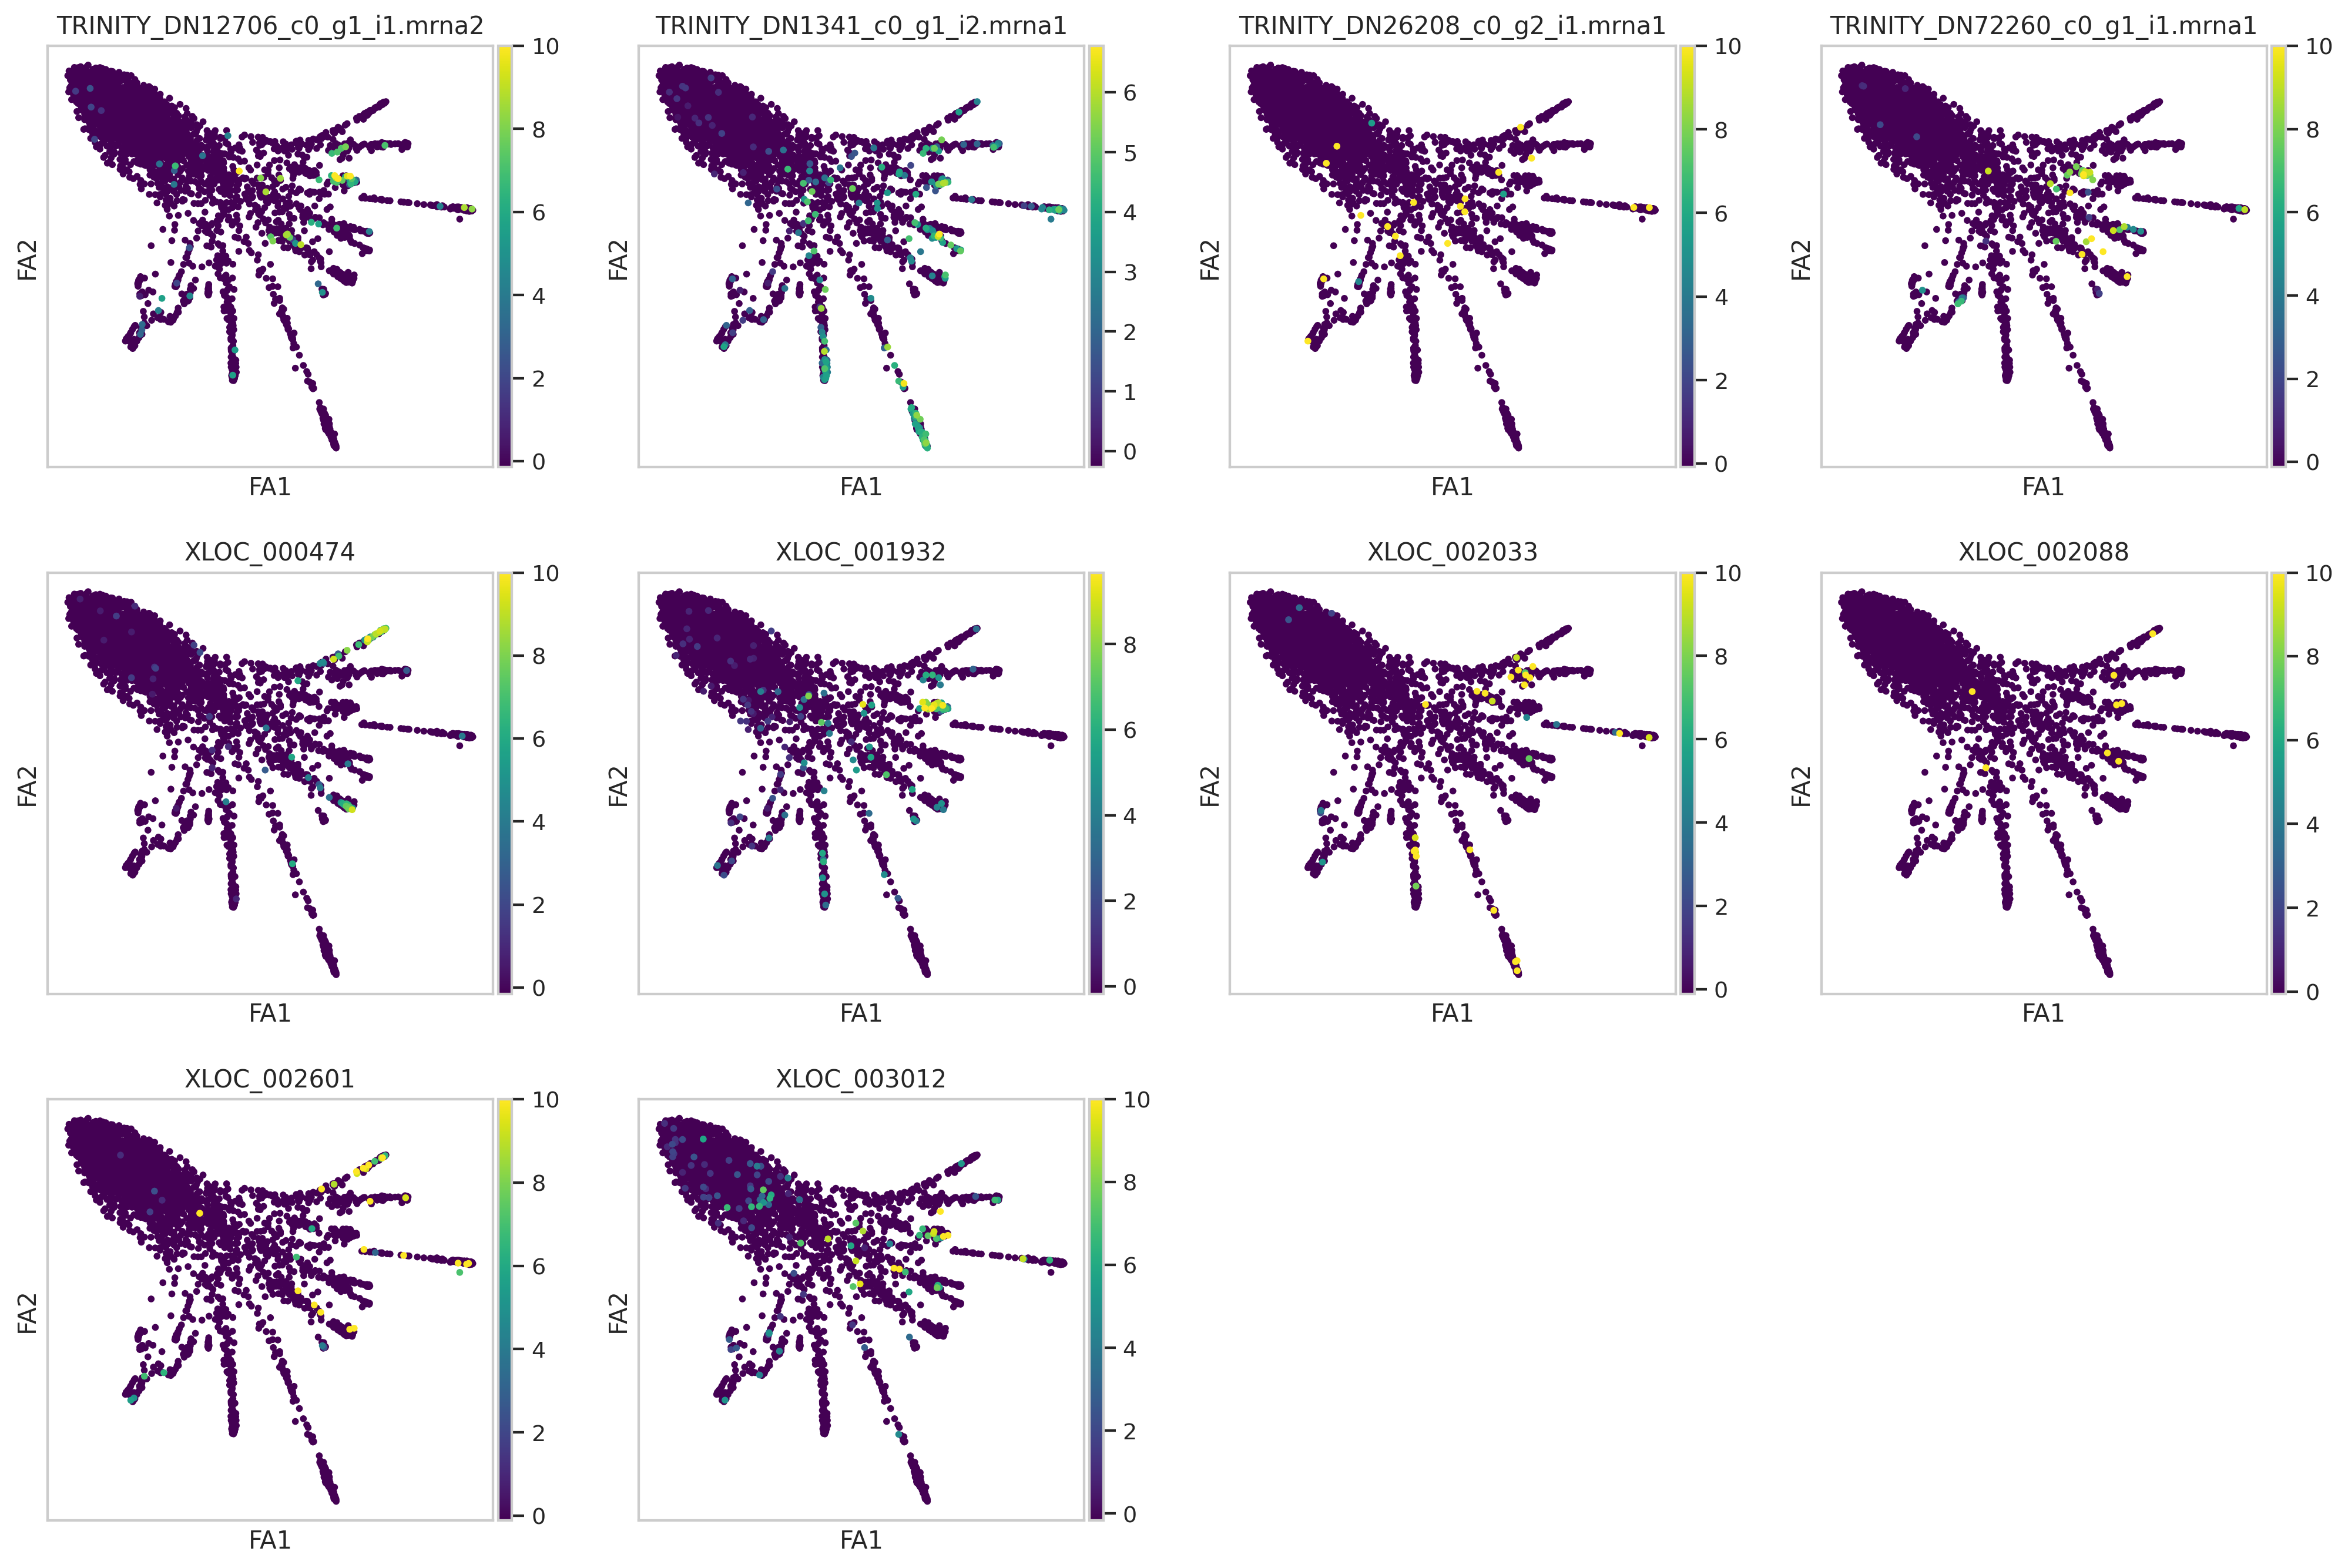

In [95]:
genes_clus = de_gene_adata[de_gene_adata.obs['louvain'].isin(['4'])].obs_names
sc.pl.draw_graph(neur_lin_scaled, color=genes_clus[0:10], 
                 legend_loc='on data',color_map='viridis')

In [97]:
clusters = []
for g in neur_gene_res.Genes:
  clus = de_gene_adata[g,:].obs['louvain'][0]
  clusters += [clus]

neur_gene_res['geneClus'] = clusters
neur_gene_res.head()

Genes  ...  geneClus
546                   XLOC_010810  ...         8
914                   XLOC_019433  ...         5
411                   XLOC_008165  ...         1
1516  TRINITY_DN89_c0_g1_i2.mrna1  ...         5
1401                  XLOC_033336  ...         1

[5 rows x 9 columns]

In [103]:
neur_gene_res.to_csv('neural_lineage_pseudotime_genes.csv')

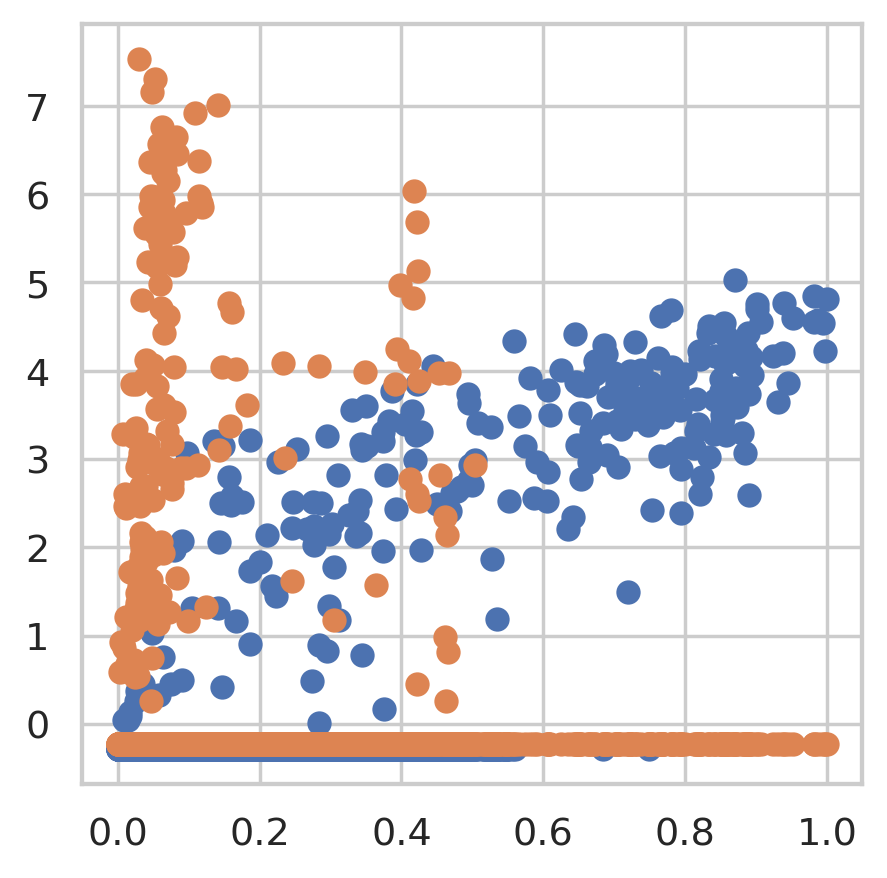

In [115]:
sub = neur_lin_scaled[:,neur_lin_scaled.var_names.isin(['XLOC_010810'])]
plt.scatter(sub.obs['dpt_pseudotime'],sub.X )

sub = neur_lin_scaled[:,neur_lin_scaled.var_names.isin(['XLOC_030920'])]
plt.scatter(sub.obs['dpt_pseudotime'],sub.X )

False

In [108]:
neur_gene_res.Genes

546                        XLOC_010810
914                        XLOC_019433
411                        XLOC_008165
1516       TRINITY_DN89_c0_g1_i2.mrna1
1401                       XLOC_033336
                     ...              
667                        XLOC_013549
355                        XLOC_006905
949     TRINITY_DN6474_c0_g1_i14.mrna2
309                        XLOC_005953
1810                       XLOC_041704
Name: Genes, Length: 494, dtype: object

###**I-cells, Neurons, Cnidocytes, Gland cells**

In [62]:
#Subset data

#I-cells, neurons, cnidocytes, gland cells
#Gland cells: 27,25,32,34,22
big_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23])]


sc.pp.filter_cells(big_lin, min_counts=0)
sc.pp.filter_genes(big_lin, min_counts=1)
sc.pp.normalize_per_cell(big_lin, counts_per_cell_after=1e4)

sc.pp.log1p(big_lin)


sc.pp.highly_variable_genes(big_lin, n_top_genes=3000)

big_lin = big_lin[:,big_lin.var['highly_variable']]

big_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4064 × 2999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

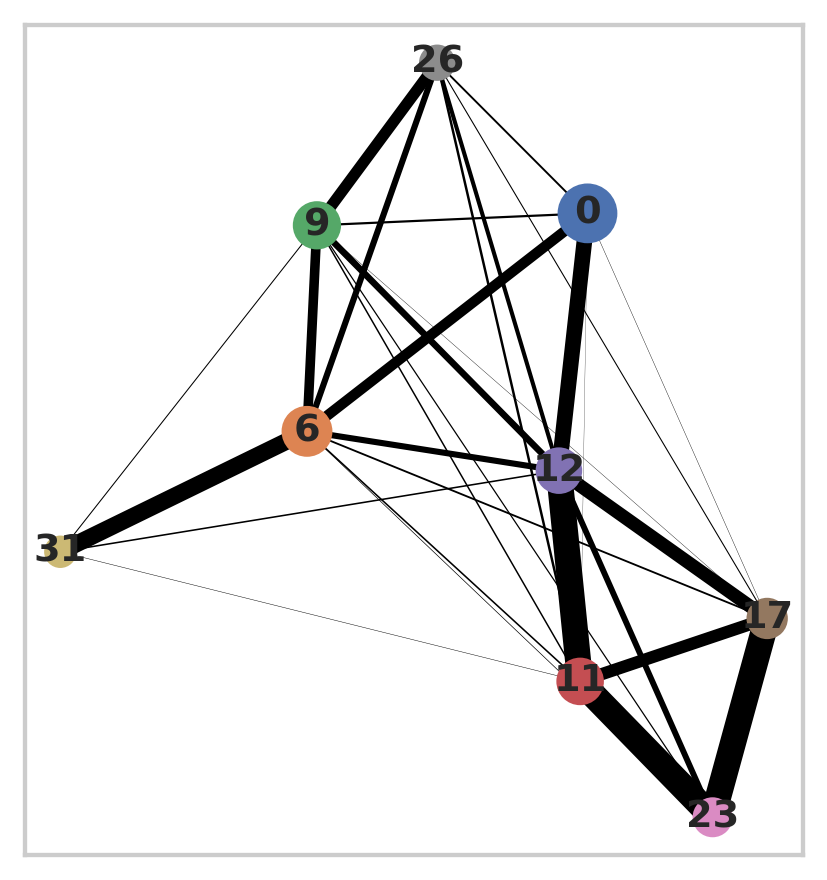

In [79]:
#Large lineage PAGA embedding
big_lin_scaled = big_lin
sc.pp.scale(big_lin_scaled, max_value=10)

sc.tl.pca(big_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(big_lin_scaled,n_neighbors=20, n_pcs=15)

#sc.tl.louvain(big_lin_scaled,resolution=0.5,key_added='louvain_test')#Clustering algorithm,resolution=0.5

#big_lin_scaled.uns['iroot'] = np.flatnonzero(big_lin_scaled.obs['cellRanger_louvain']  == 0)[0]
#sc.tl.diffmap(big_lin_scaled)

#sc.tl.dpt(big_lin_scaled,n_branchings = 2)
#sc.pp.neighbors(big_lin_scaled, n_neighbors=20, use_rep='X_diffmap')

# #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.paga(big_lin_scaled, groups='cellRanger_louvain',)
sc.pl.paga(big_lin_scaled, color=['cellRanger_louvain'])

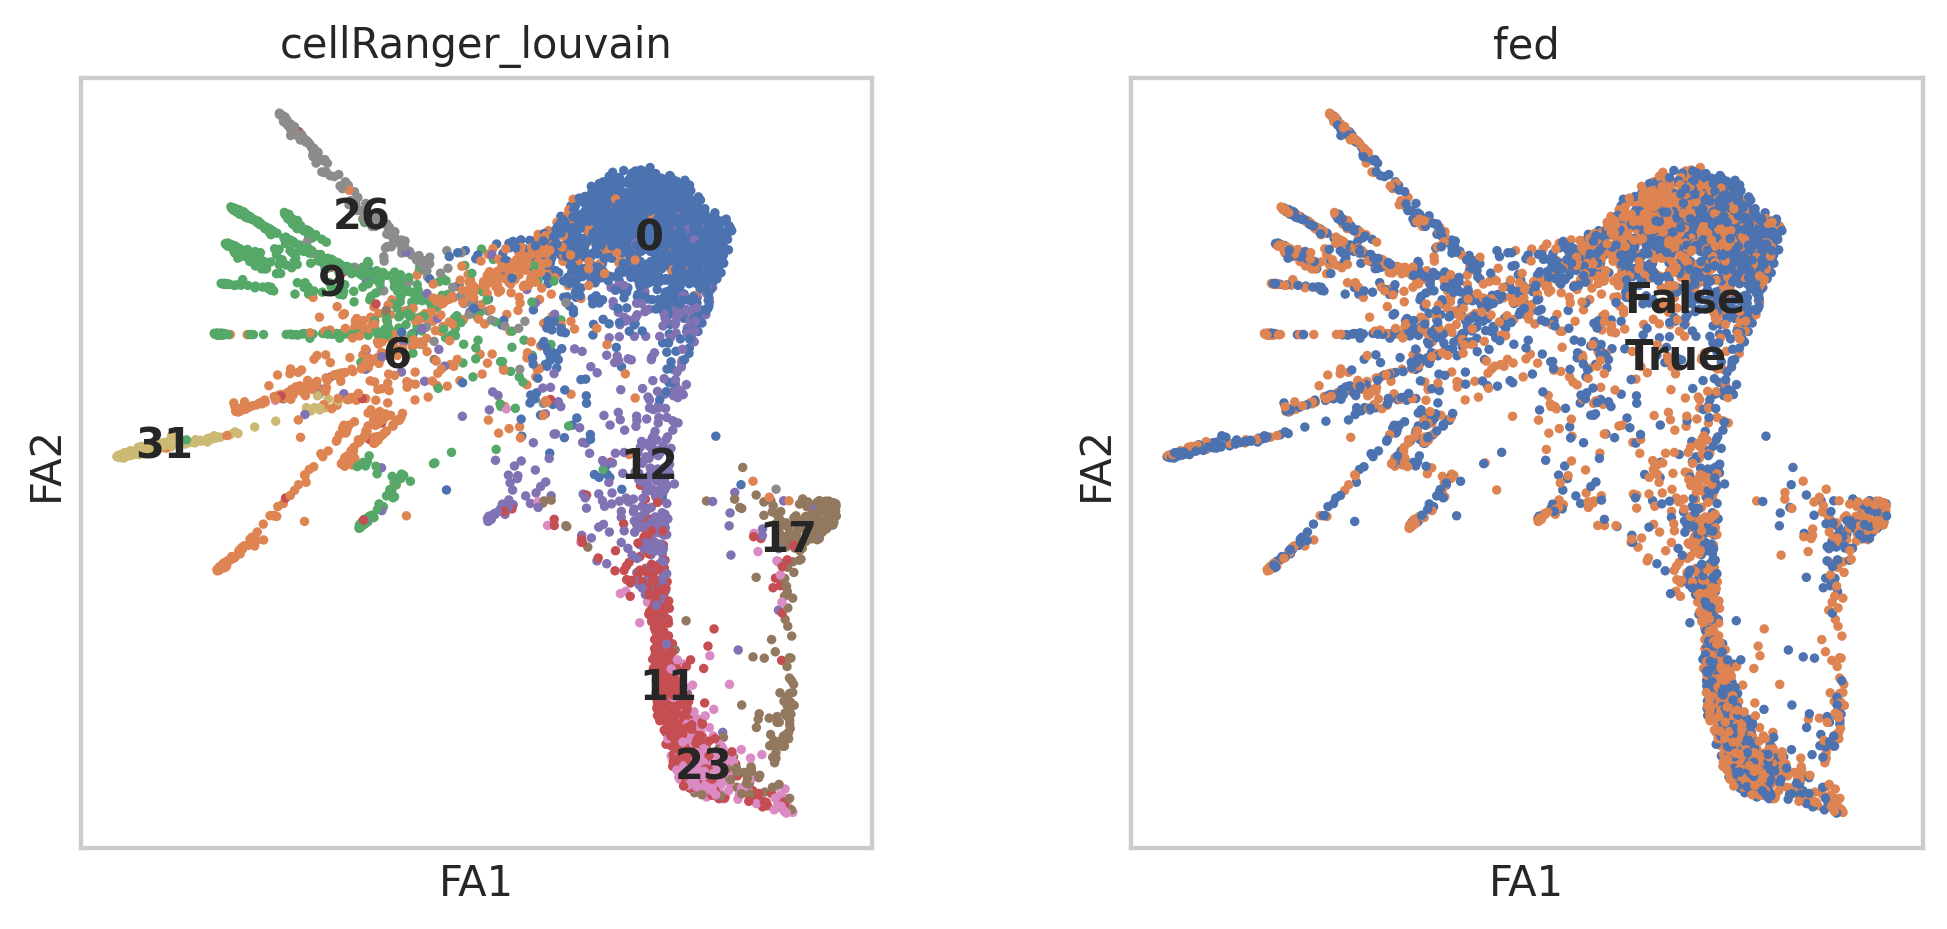

In [81]:
sc.tl.draw_graph(big_lin_scaled, init_pos='paga')
sc.pl.draw_graph(big_lin_scaled, color=['cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis')

In [107]:
big_lin_scaled

AnnData object with n_obs × n_vars = 4698 × 3000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'iroot', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips', 'paga', 'cellRanger_louvain_sizes', 'cellRanger_louvain_colors', 'draw_graph', 'fed_colors'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'